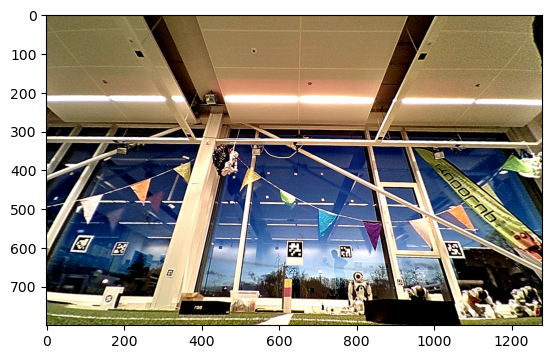

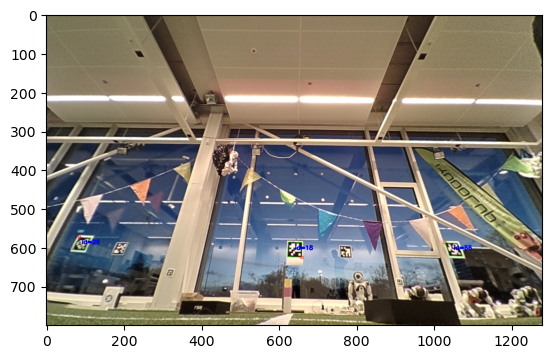

In [38]:
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

RETDICT = {
    aruco.DICT_7X7_100: "DICT_7X7_100",
    aruco.DICT_APRILTAG_36h11: "DICT_APRILTAG_36h11",
    aruco.DICT_6X6_100: "DICT_6X6_100",
}


# Dimensions in mm
A = 9000  # Field length
B = 6000  # Field width
C = 50  # Line width
D = 100  # Penalty mark size
E = 600  # Goal area length
F = 2200  # Goal area width
G = 1650  # Penalty area length
H = 4000  # Penalty area width
I = 1300  # Penalty mark distance
J = 1500  # Center circle diameter
K = 2700  # Border strip width

# Unique marker keys with (x, x, z (in mm), length_of_square (in m))
markers = {
    # window
    # "36H11_
    "79": (-4500, 1060 + 3000 + 50, 510, 0.08),
    # "36H11_
    "26": (-4500 + 450, 130 + 1060 + 3000 + 50, 1080, 0.235),
    # "36H12_
    "67": (-4500 + 450 + 530 + 80, 130 + 1060 + 3000 + 50, 1000, 0.2),
    # "36H11_
    "69": (-1800, 620 + 3000 + 50, 500, 0.08),
    # "36H11_
    "18": (0, 130 + 1060 + 3000 + 50, 1050, 0.28),
    # "36H12_
    "47": (840, 130 + 1060 + 3000 + 50, 1050, 0.2),
    # "36H11_
    "9": (840 + 850, 1060 + 3000 + 50, 500, 0.08),
    # "36H11_
    "66": (840 + 850 + 1150, 130 + 1060 + 3000 + 50, 1100, 0.235),
    # tables
    # "36H11_
    "39": (4500, 1100, 500, 0.08),
    # "36H11_
    "46": (4550 + 820, 0, 1680, 0.235),  # the one up
    # "36H12_
    "57": (4550 + 820, 0, 1000, 0.2),  # the lower one
    # "36H11_
    "49": (4500, -1100, 500, 0.08),
    # wall
    # "36H11_
    "16": (2850, -2000 - 3005, 1070, 0.235),
    # "36H11_
    "19": (2850 - 1050, -2000 - 3005, 510, 0.08),
    # "7x7_
    "37": (2850 - 1050 - 850, -2000 - 3005, 1000, 0.2),
    # "36H11_
    "8": (2850 - 1050 - 850 - 1050, -2000 - 3005, 500, 0.08),  # one on the bottom
    # "36H11_
    "29": (2850 - 1050 - 850 - 1050, -2000 - 3005, 1060, 0.275),  # one on top
    # "36H11_
    "59": (-2800 + 1050, -120 - 3005, 510, 0.08),  # column one
    # "7x7_
    "27": (-2800, -2000 - 3005, 1000, 0.2),  #
    # "36H11_
    "36": (-2800 - 900, -2000 - 3005, 1080, 0.235),
    # ducks
    # "7x7_
    "7": (-4600 - 50 - 930, 0, 1680, 0.2),  # lower one in column
    # "36H11_
    "56": (-4600 - 50 - 930, 0, 1000, 0.235),  # top one in column
    # "36H11_
    "89": (-4500, -1100, 450, 0.08),
    # "36H11_
    "99": (-4500, 1100, 500, 0.08),  # window
}


def detect_aruco_markers(image):
    # Convert the image to grayscale
    # UnSharpen the image
    blurred = cv2.GaussianBlur(image, (3, 3), 5)
    image = cv2.addWeighted(image, 3, blurred, -2, 0)

    # Sharpness filter 4x4
    sharpen_filter = np.array(
        [[-1, -1, -1, -1], [-1, 9, 9, -1], [-1, 9, 9, -1], [-1, -1, -1, -1]]
    )
    sharpened = cv2.filter2D(image, cv2.CV_8U, sharpen_filter)
    image = cv2.addWeighted(image, 1.5, sharpened, -0.25, 0)
    plt.imshow(image[..., ::-1])
    plt.show()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    retdict = RETDICT.copy()

    for key in retdict:
        aruco_dict = aruco.Dictionary_get(key)
        parameters = aruco.DetectorParameters_create()
        parameters.adaptiveThreshWinSizeStep = 1
        parameters.adaptiveThreshWinSizeMin = 3
        parameters.aprilTagMinWhiteBlackDiff = 3

        corners, ids, rejectedImgPoints = aruco.detectMarkers(
            gray, aruco_dict, parameters=parameters
        )
        retdict[key] = (corners, ids, rejectedImgPoints)
    return retdict


# Load the image
image_path = "center_field_markers.png"
image = cv2.imread(image_path)

# Detect AruCo markers
retdict = detect_aruco_markers(image)

# Get the detected markers
viz = image.copy()
for key, desci in RETDICT.items():
    corners, ids, rejectedImgPoints = retdict[key]
    if ids is not None:
        viz = aruco.drawDetectedMarkers(viz, corners, ids)
plt.imshow(viz[..., ::-1])


In [7]:
def triangulate_position(markers, retdict):
    positions = []
    for marker_id, (x, y, z, size) in markers.items():
        for key, (corners, ids, _) in retdict.items():
            if ids is not None:
                for i, id in enumerate(ids):
                    if str(id[0]) == marker_id:
                        # Calculate the center of the marker
                        c = corners[i][0]
                        center_x = int((c[0][0] + c[1][0] + c[2][0] + c[3][0]) / 4)
                        center_y = int((c[0][1] + c[1][1] + c[2][1] + c[3][1]) / 4)
                        positions.append((marker_id, center_x, center_y, x, y, z))
    return positions

positions = triangulate_position(markers, retdict)
for pos in positions:
    print(f"Marker ID: {pos[0]}, Image Position: ({pos[1]}, {pos[2]}), Real World Position: ({pos[3]}, {pos[4]}, {pos[5]})")

Marker ID: 26, Image Position: (91, 590), Real World Position: (-4050, 4240, 1080)
Marker ID: 18, Image Position: (642, 604), Real World Position: (0, 4240, 1050)
Marker ID: 66, Image Position: (1051, 604), Real World Position: (2840, 4240, 1100)


In [19]:
def solve_pnp(positions, camera_matrix, dist_coeffs):
    # Prepare 3D points and 2D points
    object_points = []
    image_points = []

    for pos in positions:
        object_points.append([pos[3], pos[4], pos[5]])  # Real world coordinates
        image_points.append([pos[1], pos[2]])  # Image coordinates

    object_points = np.array(object_points, dtype=np.float32)
    image_points = np.array(image_points, dtype=np.float32)

    # Solve PnP
    success, rotation_vector, translation_vector = cv2.solvePnP(
        object_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_SQPNP
    )

    if success:
        return rotation_vector, translation_vector
    else:
        return None, None

# Example camera matrix and distortion coefficients (you need to calibrate your camera to get these values)
camera_matrix = np.loadtxt("mtx")
dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

rotation_vector, translation_vector = solve_pnp(positions, camera_matrix, dist_coeffs)

if rotation_vector is not None and translation_vector is not None:
    print(f"Rotation Vector:\n{rotation_vector}")
    print(f"Translation Vector:\n{translation_vector}")
else:
    print("PnP solution could not be found.")

Rotation Vector:
[[ 0.92230817]
 [ 0.0353787 ]
 [-0.01174495]]
Translation Vector:
[[-103.4183081 ]
 [-251.00290312]
 [  82.36489972]]
